# Tau PT Regression + JetID Classification Merge

In this notebook we will implement a NN that merges the regression and classification NN that we developed for pT regression and jetID, respectively.

In [1]:
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D
from qkeras.utils import load_qmodel

import hist
from hist import Hist

import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

2023-10-16 15:14:24.621615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:14:24.734228: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 15:14:24.737558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-16 15:14:24.737569: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [2]:
seed = 1111
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


ntuples_dataset_path = "../../ntuples/Jan_25_2023"

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 11.5
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 11
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    #print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.64
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    print("bob")
    print(len(X_sig) / len(X_train))
    print((len(X_bkg) + len(X_qcd)) / len(X_train))

    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data(ntuples_dataset_path, train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data(ntuples_dataset_path, train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

bob
0.48803825490353586
0.5119617450964642
bob
0.19763209133016482
0.8023679086698352


### Analyzing Performance

In [3]:
# LOADING IN MODELS

model_jetID_separate_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_jetID_separate = load_model(model_jetID_separate_name) # This is the ID model that Duc trained previously (separate tagger)

model_pt_regress_separate_name = "../models/pt_regress_v1_bestest.h5"
model_pt_regress_separate = load_model("../models/pt_regress_v1_bestest.h5") # separate pT regressor (the one trained by Orion)

model_merged_name = "../models/new_merged.h5"
model_merged = load_model(model_merged_name)

model_merged_quantized_name = "../models/quantized_merged_new_gamma30.h5"
model_merged_quantized = load_qmodel(model_merged_quantized_name) # This is the intermediate model to our final model (merged and quantized, but not pruned)

model_merged_quantized_pruned_name = "../models/quantized_merged_pruned_gamma30.h5"
model_merged_quantized_pruned = load_qmodel(model_merged_quantized_pruned_name) # Merged, quantized, pruned model (final model)

2023-10-16 15:14:45.616845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
   
    
    hist_pred_pt, edges_pred_pt = np.histogram(pred_pt, bins=20, range = (0,300), density = True)
    errors_pred_pt = np.sqrt(hist_pred_pt*len(pred_pt)) / len(pred_pt)
    bin_centers_pred_pt = 0.5 * (edges_pred_pt[:-1] + edges_pred_pt[1:])
    
    hist_reco, edges_reco = np.histogram(reco_pt_selected, bins=20, range = (0,300), density = True)
    errors_reco = np.sqrt(hist_reco*len(reco_pt_selected)) / len(reco_pt_selected)
    bin_centers_reco = 0.5 * (edges_reco[:-1] + edges_reco[1:])
    
    hist_truth, edges_truth = np.histogram(truth_pt_selected, bins=20, range = (0,300), density = True)
    errors_truth = np.sqrt(hist_truth*len(truth_pt_selected)) / len(truth_pt_selected)
    bin_centers_truth = 0.5 * (edges_truth[:-1] + edges_truth[1:])

    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)
    plt.errorbar(bin_centers_pred_pt, hist_pred_pt, yerr=errors_pred_pt, fmt='ro', color = "#2ca02c", linewidth = 2, alpha = 0.5)
    plt.errorbar(bin_centers_reco, hist_reco, yerr=errors_pred_pt, fmt='ro', color = '#ff7f0e', linewidth = 2, alpha = 0.5)
    plt.errorbar(bin_centers_truth, hist_truth, yerr=errors_truth, fmt='ro', color = '#1f77b4', linewidth = 2, alpha = 0.5)
    plt.ylim(0, 0.018)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 1s 530us/step


/tmp/ipykernel_3762294/3961494979.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(bin_centers_pred_pt, hist_pred_pt, yerr=errors_pred_pt, fmt='ro', color = "#2ca02c", linewidth = 2, alpha = 0.5)
/tmp/ipykernel_3762294/3961494979.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(bin_centers_reco, hist_reco, yerr=errors_pred_pt, fmt='ro', color = '#ff7f0e', linewidth = 2, alpha = 0.5)
/tmp/ipykernel_3762294/3961494979.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(bin_centers_truth, hist_truth, yerr=errors_truth, fmt='ro', color = '#1f77b4', linewidth = 2, alpha = 0.5)


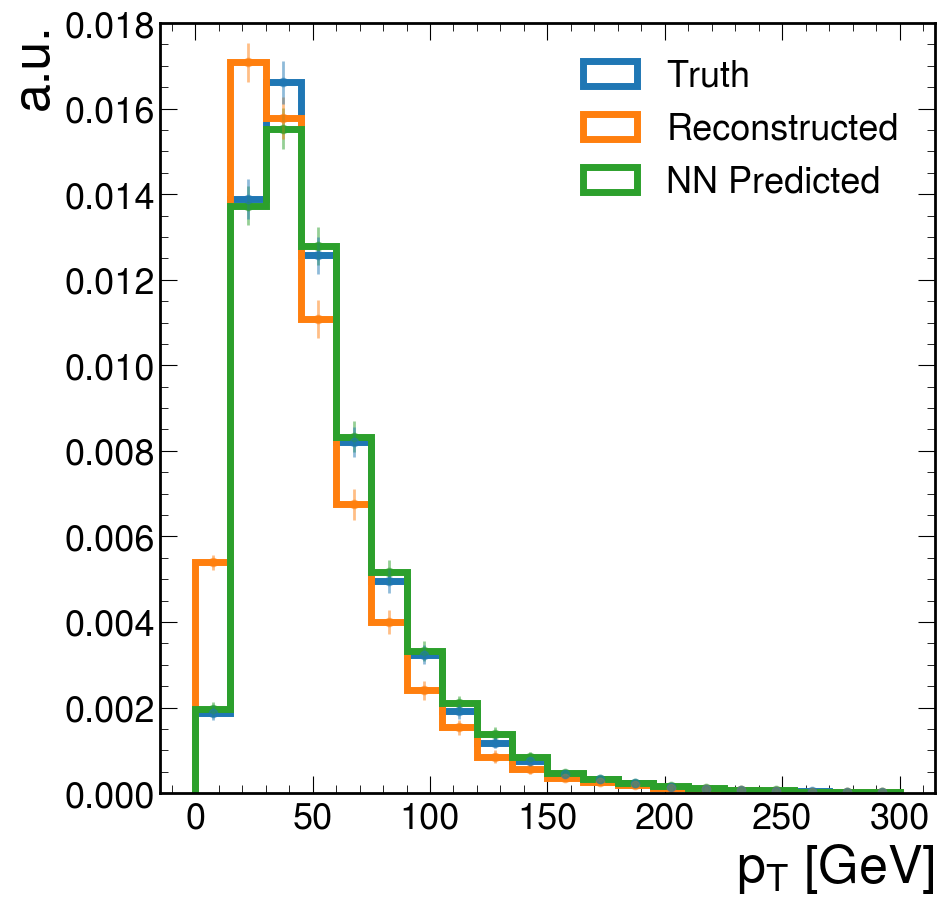

In [5]:
load_and_predict_test(ntuples_dataset_path, model_merged)

### Combined ROC Curve

In [10]:
def prep_rate_data(NormalModelID, 
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(NormalModelID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = model_pt_regress_separate # updated separate pT regressor trained by Orion
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'No $p_T$ Correction',linewidth=3)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'ID + $p_T$ correction separate',linewidth=3)
    
    
    
#=======================================================================================================    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(3):
        if i == 0:
            modelID = model_merged # merged
            model_regress = model_merged
        elif i == 1:
            modelID = model_merged_quantized # merged quantized
            model_regress = model_merged_quantized
        elif i == 2:
            modelID = model_merged_quantized_pruned # merged quantized pruned
            model_regress = model_merged_quantized_pruned

        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
        
        if i == 0:
            plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged Full-bits, $\gamma=0.7$',linewidth=3)
        elif i == 1:
            plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged Quantized, $\gamma=0.3$',linewidth=3)
        elif i == 2:
            plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged Quantized + Pruned, $\gamma=0.3$',linewidth=3)
    
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")

    plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
    plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

    plt.yscale('log')
    plt.legend(loc='best',fontsize=18)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 18)

    plt.plot([],[], 'none', label=r'(MinBias $p_T$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()

    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 763us/step


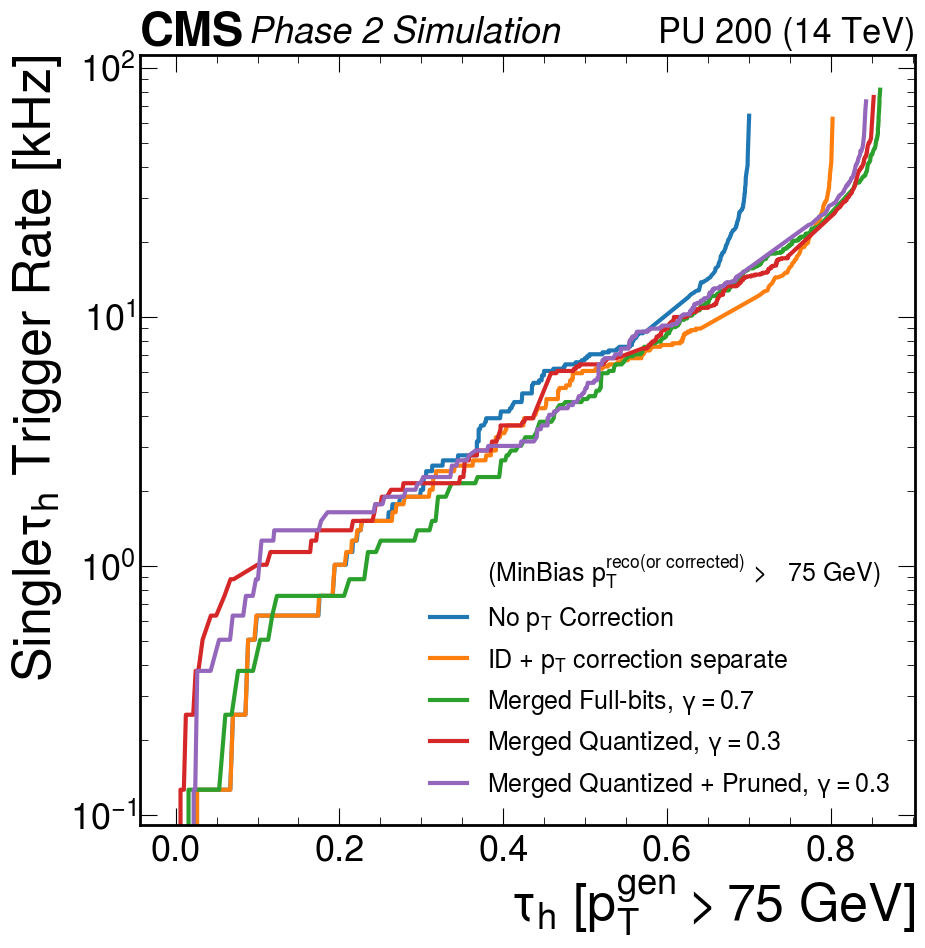

In [11]:
n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_jetID_separate_name,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

In [8]:
def plot_pt_eff_puppi(Official_Model,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=34.,
                      cut_point = 0.22):
    '''
    cut_point = 0.22. We accept anything larger than this. 
    The corresponding corrected pT cut is 34 GeV.
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]

    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    #0 index is id, 1 is pT regression
    model = Official_Model

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]
    
    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
       
    ratio_predict = model.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
    selection_num_corrected = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    #PUPPI only pT
    puppi_pT = truth_tau_pt[selection_num]
    
    #corrected pT
    truth_tau_pt_select = truth_tau_pt[selection_num_corrected]

    X_sig = np.asarray(sig_input[selection_num_corrected])
    y_sig = model.predict(np.nan_to_num(X_sig))[0]

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(puppi_pT)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Merged Tau NN (NN Score > {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = r'PUPPI $\epsilon$ (no $p_T$ correction)')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 28 kHz)")
    plt.legend(loc = 'best', fontsize=20)
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

1328/1328 [==============================] - 1s 771us/step


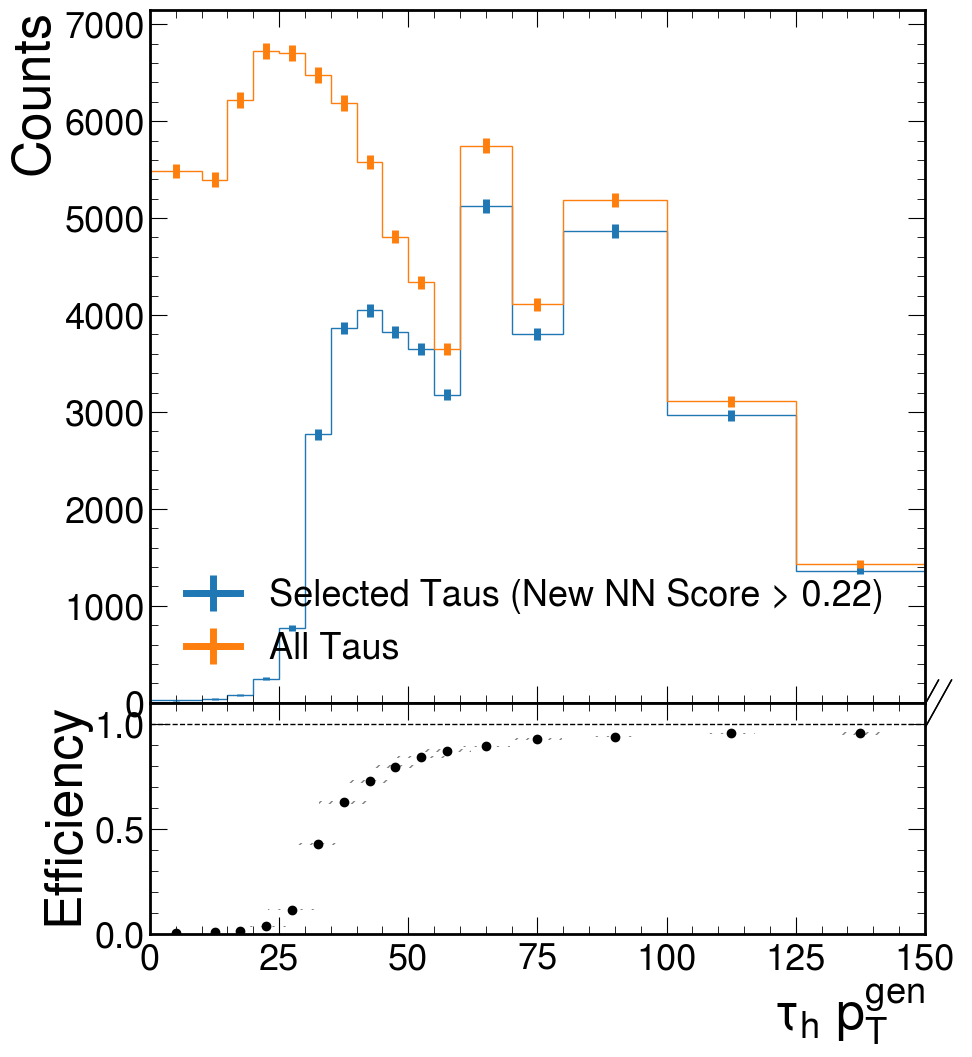

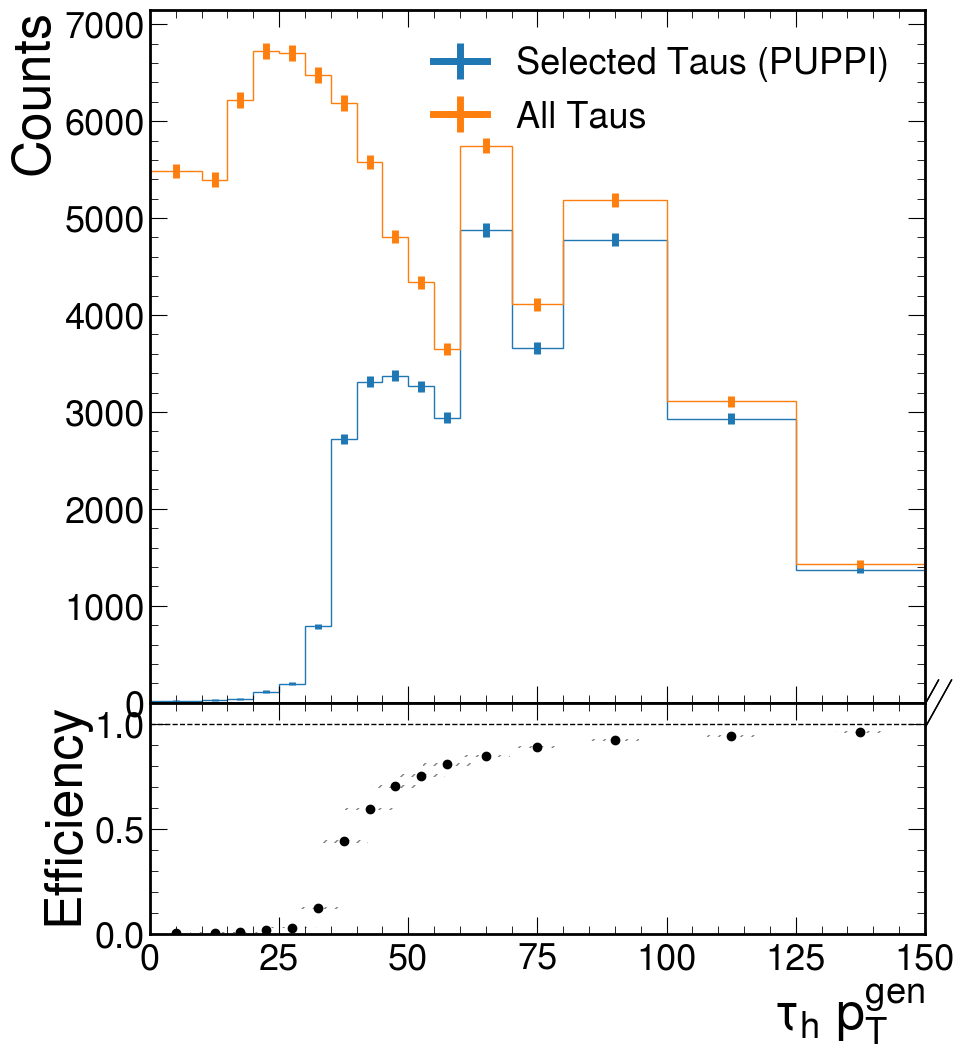

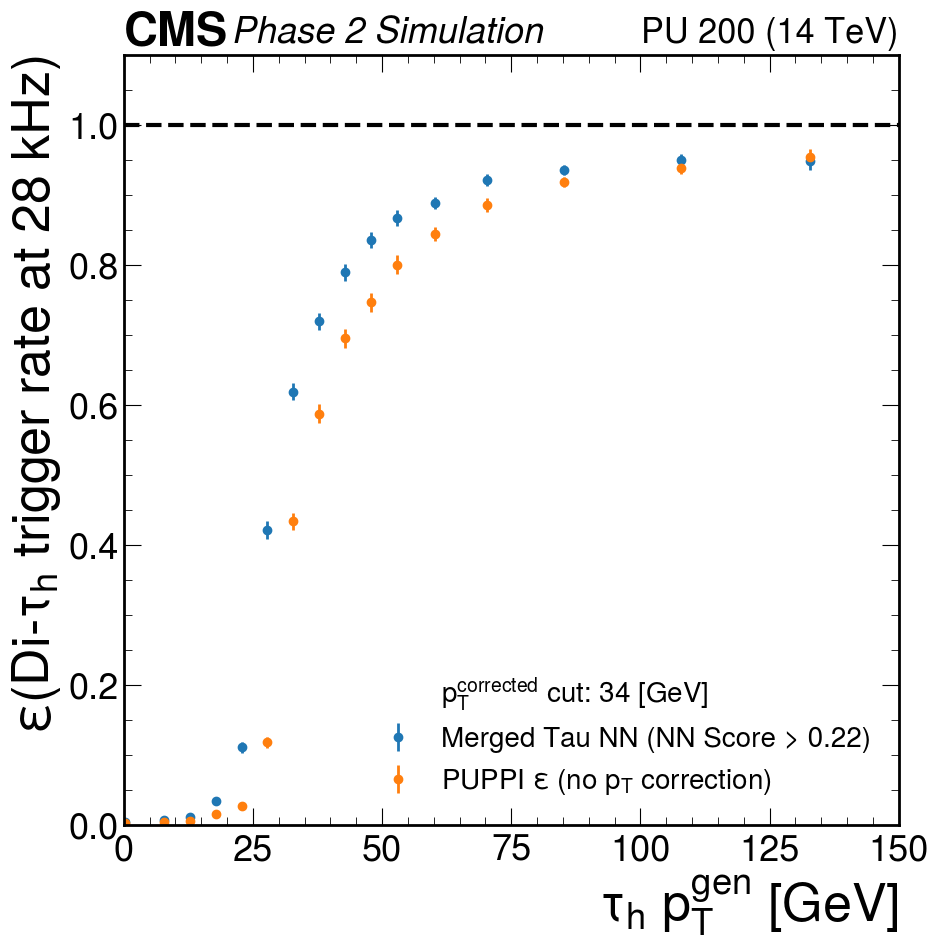

In [9]:
results = plot_pt_eff_puppi(model_merged_quantized_pruned,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=34.,
                            cut_point = 0.22)

# Barrel

In [13]:
def plot_pt_eff_puppi(Official_Model,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=34.,
                      cut_point = 0.22):
    '''
    cut_point = 0.22. We accept anything larger than this. 
    The corresponding corrected pT cut is 34 GeV.
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]

    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    #0 index is id, 1 is pT regression
    model = Official_Model

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]
    
    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 1.5) #"genpt1 > 1. && abs(geneta1) < 2.1 "
       
    ratio_predict = model.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
    selection_num_corrected = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    #PUPPI only pT
    puppi_pT = truth_tau_pt[selection_num]
    
    #corrected pT
    truth_tau_pt_select = truth_tau_pt[selection_num_corrected]

    X_sig = np.asarray(sig_input[selection_num_corrected])
    y_sig = model.predict(np.nan_to_num(X_sig))[0]

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(puppi_pT)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Merged Tau NN (NN Score > {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = r'PUPPI $\epsilon$ (no $p_T$ correction)')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 28 kHz)")
    plt.legend(loc = 'best', fontsize=20)
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

1076/1076 [==============================] - 1s 778us/step


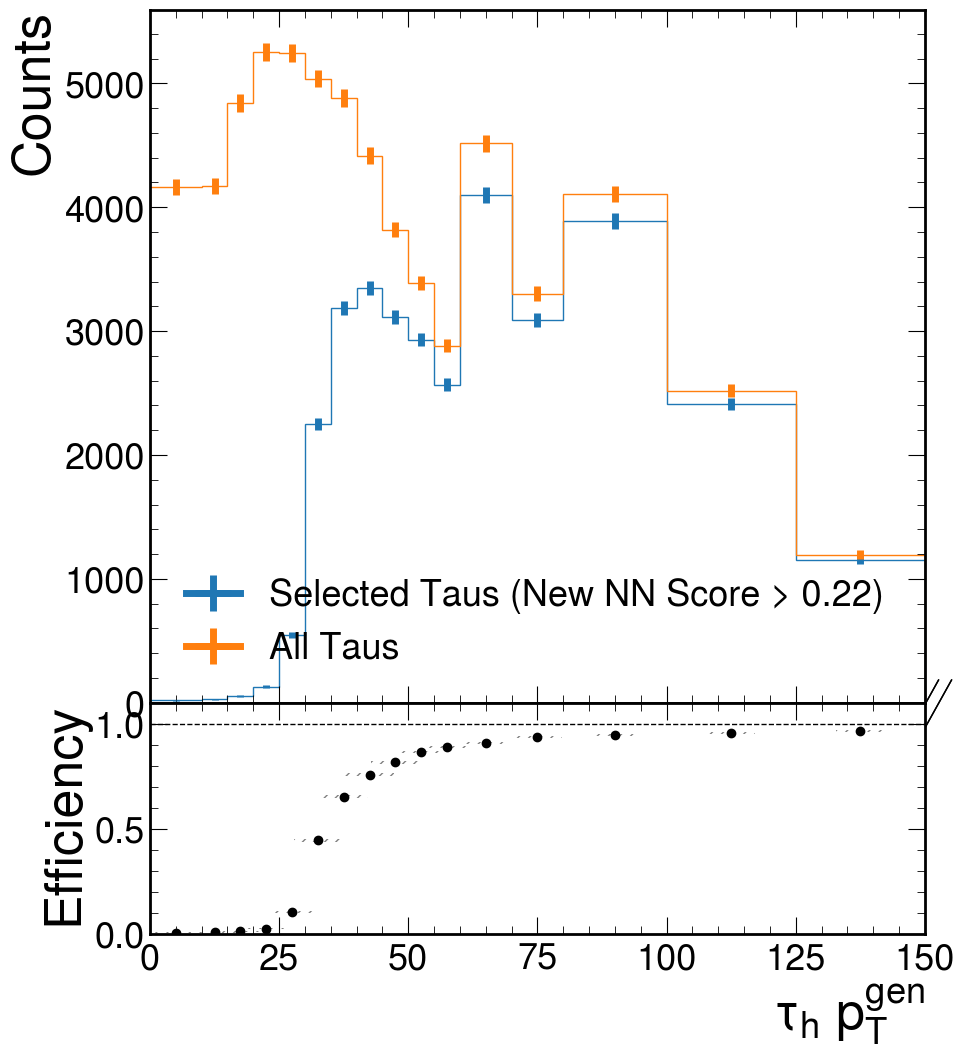

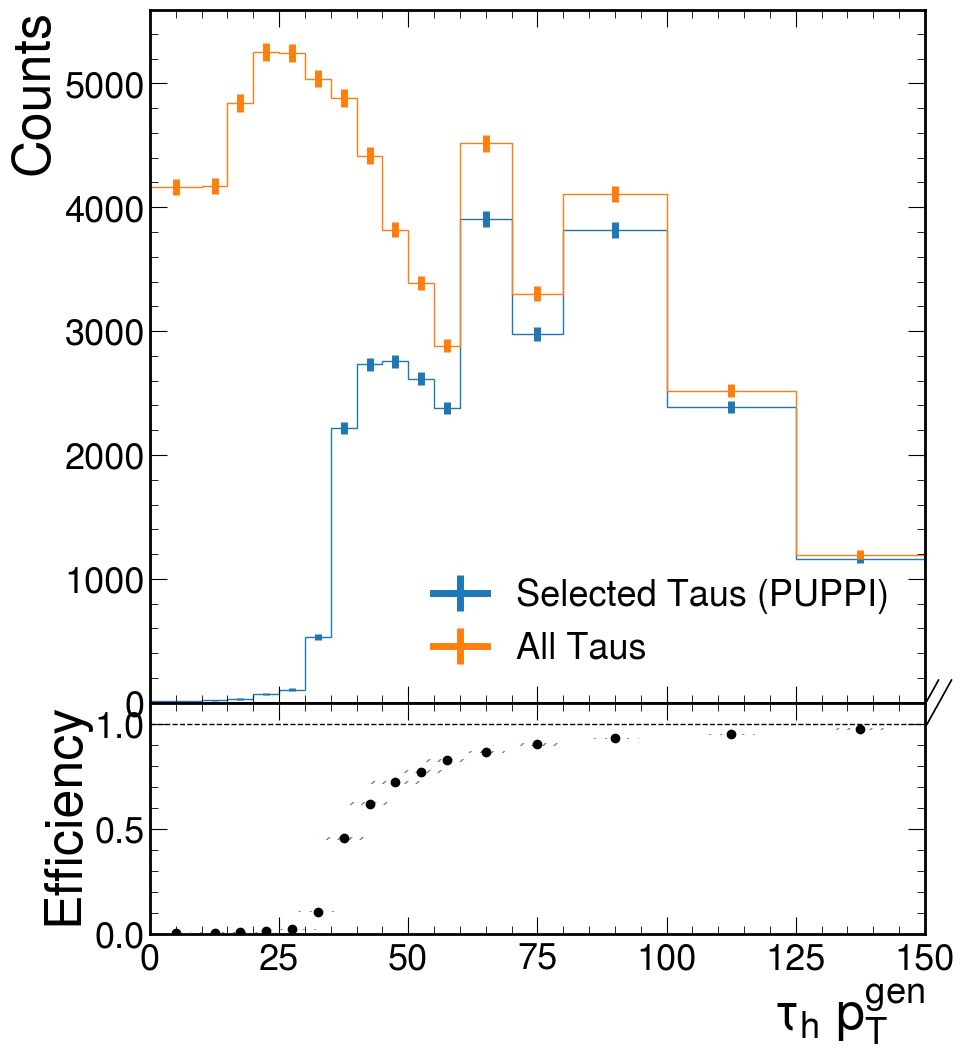

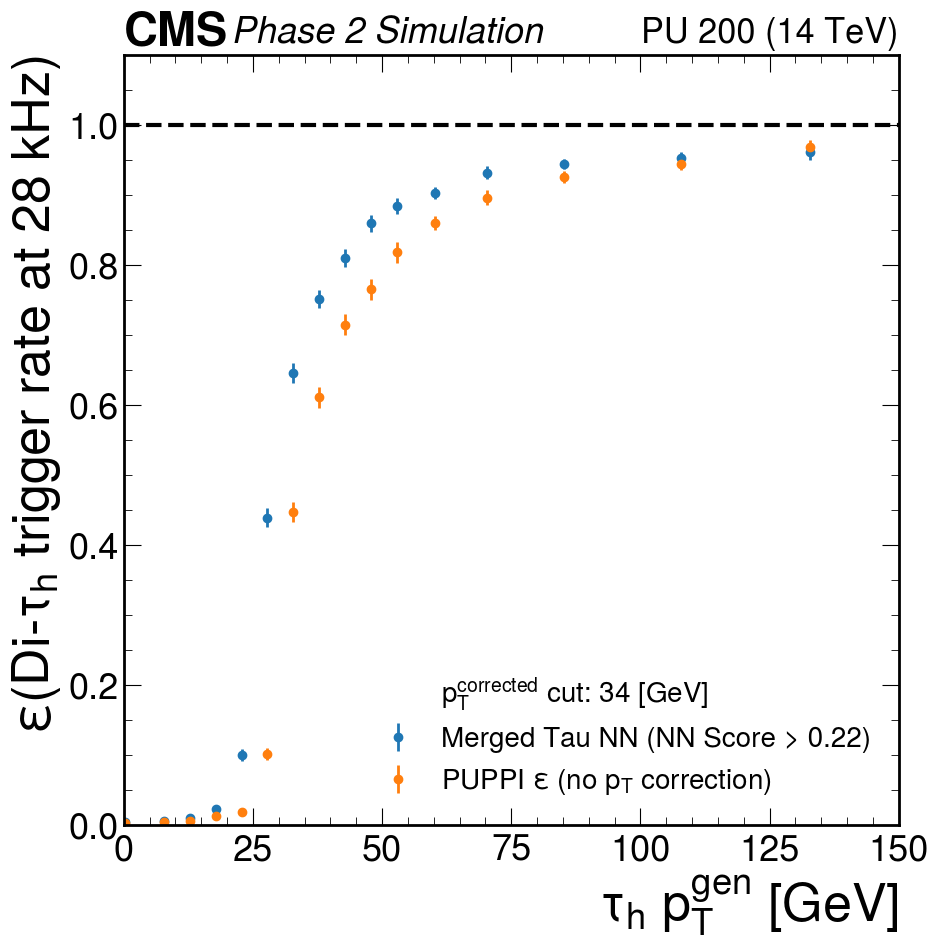

In [14]:
results = plot_pt_eff_puppi(model_merged_quantized_pruned,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=34.,
                            cut_point = 0.22)

# Endcap

In [29]:
def plot_pt_eff_puppi(Official_Model,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=34.,
                      cut_point = 0.22):
    '''
    cut_point = 0.22. We accept anything larger than this. 
    The corresponding corrected pT cut is 34 GeV.
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]

    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    #0 index is id, 1 is pT regression
    model = Official_Model

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]
    
    selection_deno = (truth_tau_pt > 1.) & (1.5 < abs(eta_sig)) & (abs(eta_sig) < 2.4) #"genpt1 > 1. && abs(geneta1) < 2.1 "
       
    ratio_predict = model.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
    selection_num_corrected = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    
    #PUPPI only pT
    puppi_pT = truth_tau_pt[selection_num]
    
    #corrected pT
    truth_tau_pt_select = truth_tau_pt[selection_num_corrected]

    X_sig = np.asarray(sig_input[selection_num_corrected])
    y_sig = model.predict(np.nan_to_num(X_sig))[0]

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(puppi_pT)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Merged Tau NN (NN Score > {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = r'PUPPI $\epsilon$ (no $p_T$ correction)')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 28 kHz)")
    plt.legend(loc = 'best', fontsize=20)
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

345/345 [==============================] - 0s 768us/step


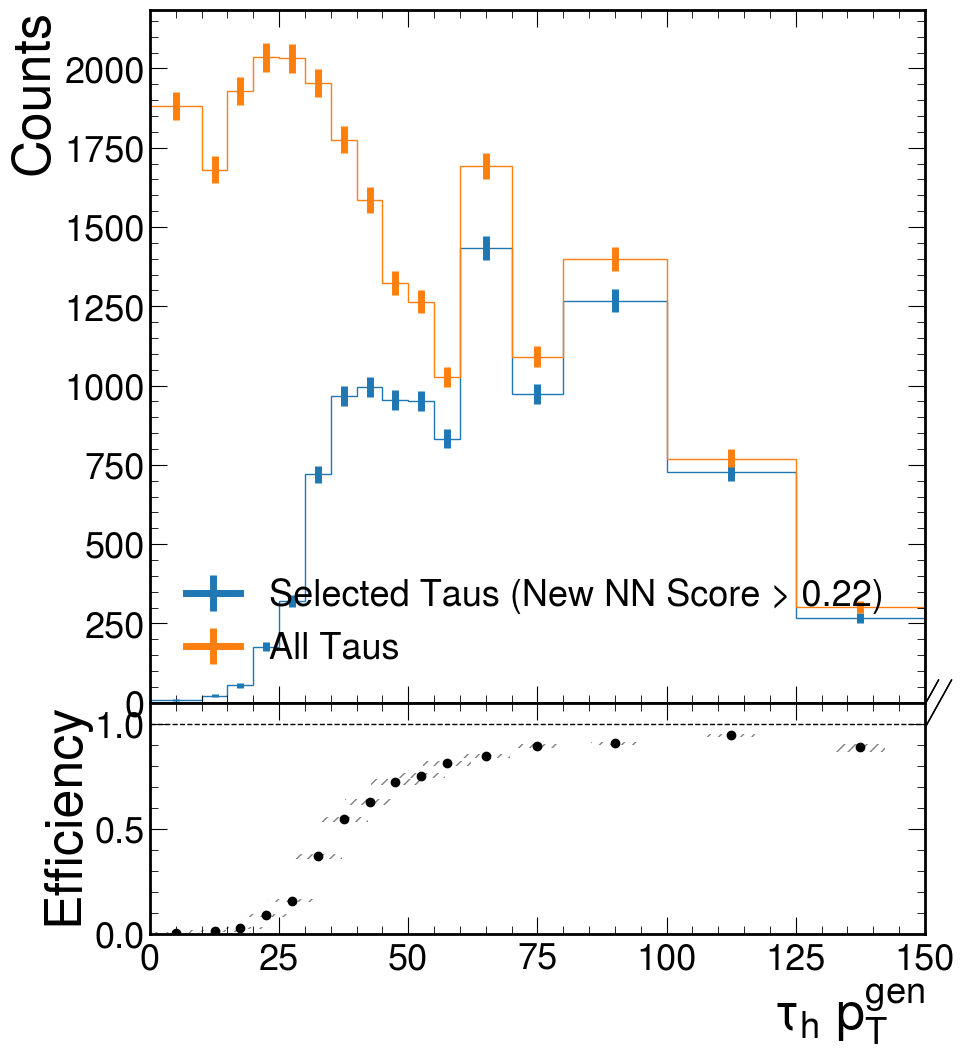

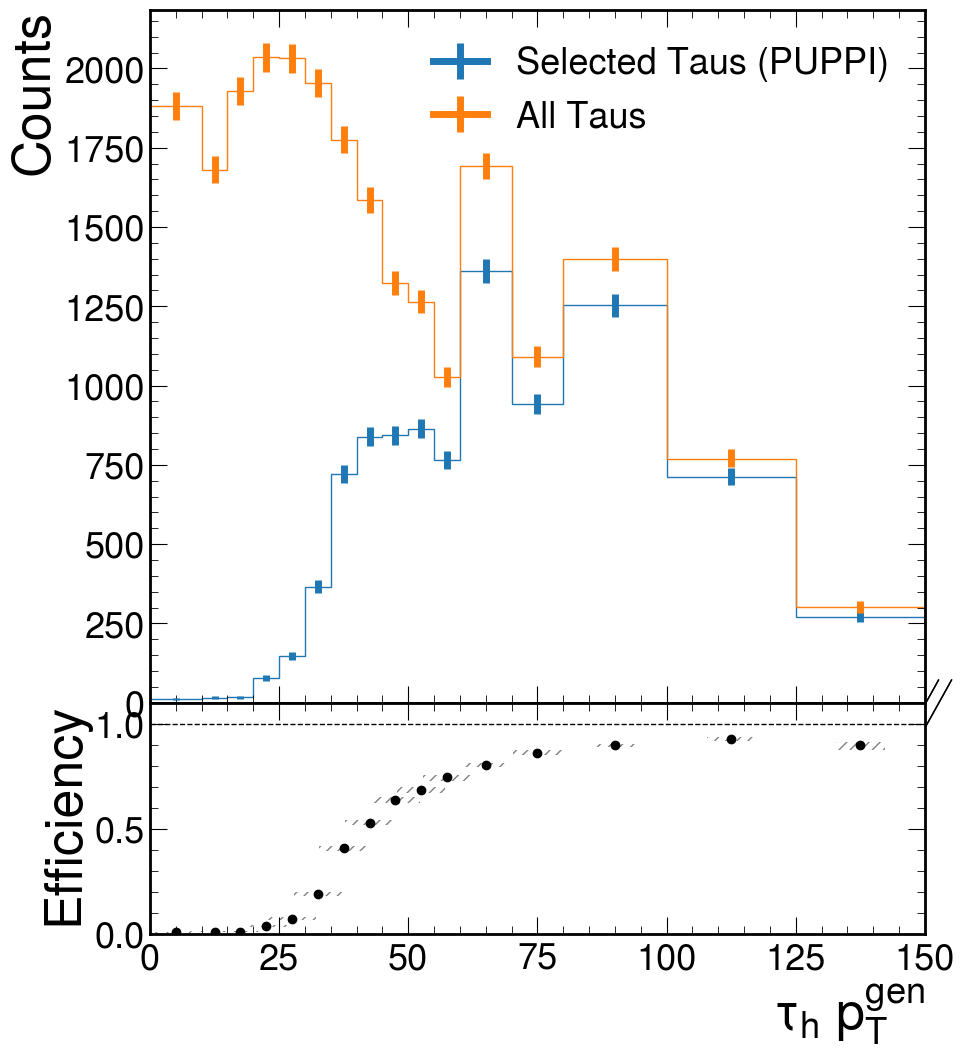

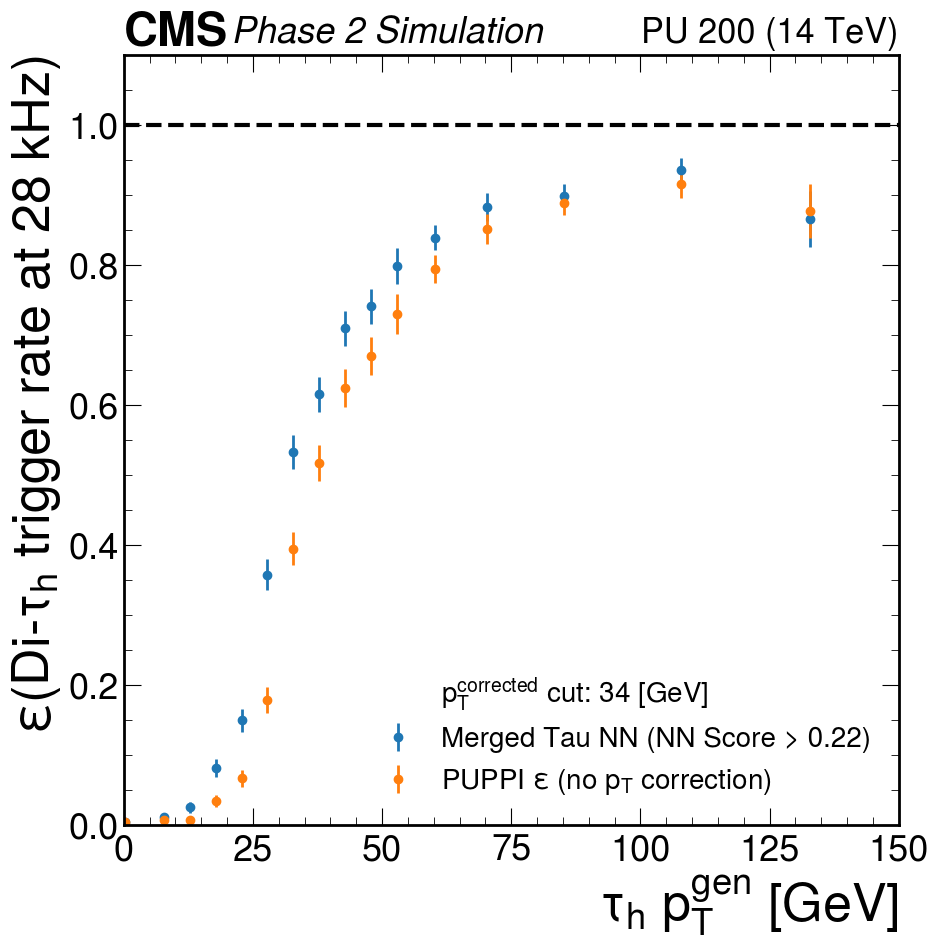

In [30]:
results = plot_pt_eff_puppi(model_merged_quantized_pruned,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=34.,
                            cut_point = 0.22)

In [11]:
def plot_eta_eff_puppi(Official_Model,
                       DataPath, 
                       treename = 'ntuplePupSingle', 
                       cut_point = 0.22, 
                       corrected_pt_cut = 34, 
                       test_indx=0):
    
    sig = uproot4.open(DataPath)
    reco_pt_sig = sig[treename]['tree']['pt'].array()[test_indx:]

    truth_tau_eta = sig[treename]['tree']['geneta1'].array()[test_indx:]
    reco_tau_eta = sig[treename]['tree']['eta'].array()[test_indx:]

    #Load model and select out the tau
    #0 index is id, 1 is pT regression
    model = Official_Model

    #Get all the inputs
    sig_input = sig[treename]['tree']['m_inputs'].array()[test_indx:]

    truth_tau_pt = sig[treename]['tree']['genpt1'].array()[test_indx:]
    deltaR_sig = sig[treename]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[treename]['tree']['geneta1'].array()[test_indx:]
    
    selection_deno = (truth_tau_pt > 60.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "

    #ratio_predict = model.predict(np.asarray(sig_input))[1].flatten()
    #corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
    #selection_num_corrected = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>1) # " abs(gendr1) < 0.4 && pt > 1."
    
    #puppi_eta = truth_tau_eta[selection_num]
    
    #Selected out the tau pt with the basic cuts first
    truth_tau_eta_select = truth_tau_eta[selection_num]
    
    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model.predict(np.nan_to_num(X_sig))[0]
    
    nn_cut = y_sig.flatten() > cut_point
    
    tau_eta_nn = np.asarray(truth_tau_eta_select)[nn_cut]

    #Fill two plots and divide the two.
    eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
    eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

    hist_all_tau = Hist(eta_axis)
    hist_puppi_tau = Hist(eta_axis)
    hist_selected_tau = Hist(eta_axis)

    hist_all_tau.fill(truth_tau_eta[selection_deno])
    hist_puppi_tau.fill(truth_tau_eta_select)
    hist_selected_tau.fill(tau_eta_nn)
    
    fig = plt.figure(figsize=(10, 12))
    main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (NN Score > 0.05)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    
    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_puppi_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Puppi tau",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )
    plt.show()
    
    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = eff_new_nn_artists.bar.datavalues


    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err = eff_puppi_artists.bar.datavalues
    
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', linewidth = 2, label = r'$E/\gamma$ PUPPI + Merged ID')
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err, fmt='o', linewidth = 2, label = r'$E/\gamma$ PUPPI')    

    plt.hlines(1, -3, 3, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.5,1.05])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $\eta^{gen}$")
    plt.ylabel(r"Efficiency ($p_T^{gen} > 60$ GeV)")
    plt.legend(loc = 'best')
    plt.show()

1626/1626 [==============================] - 1s 828us/step


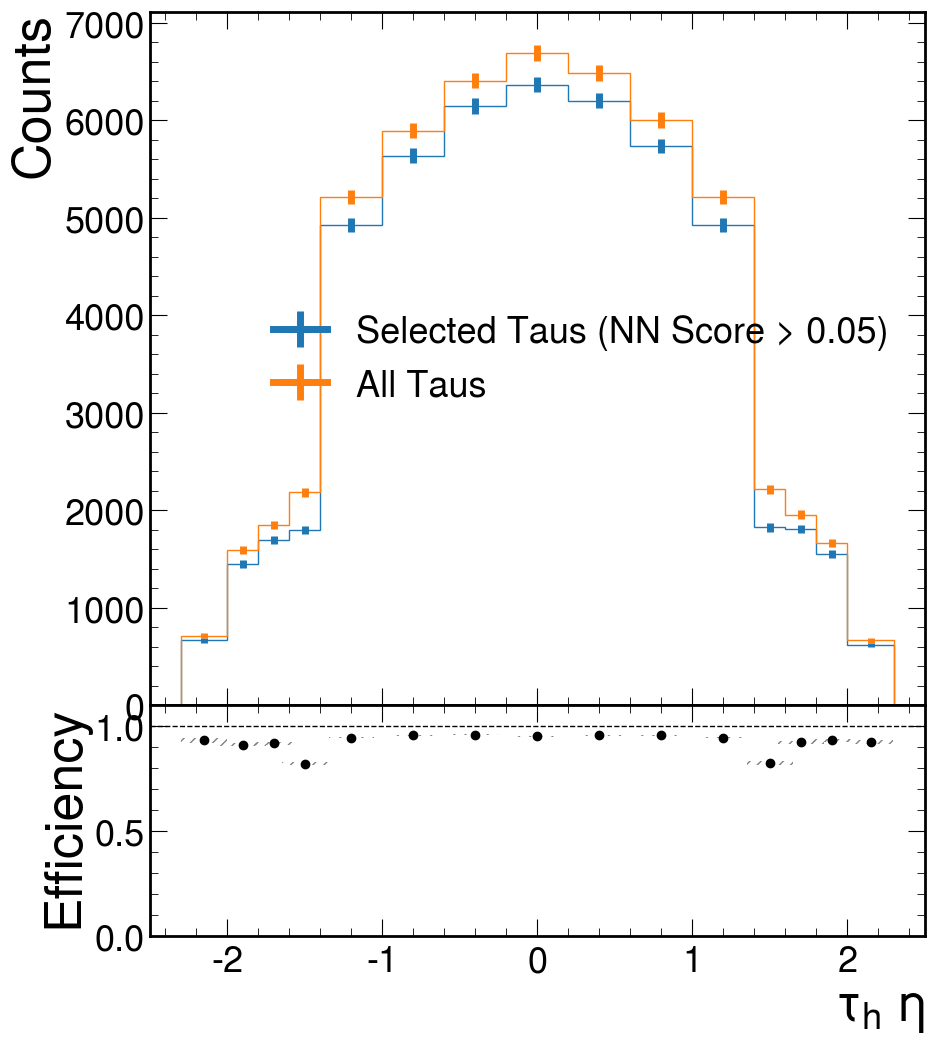

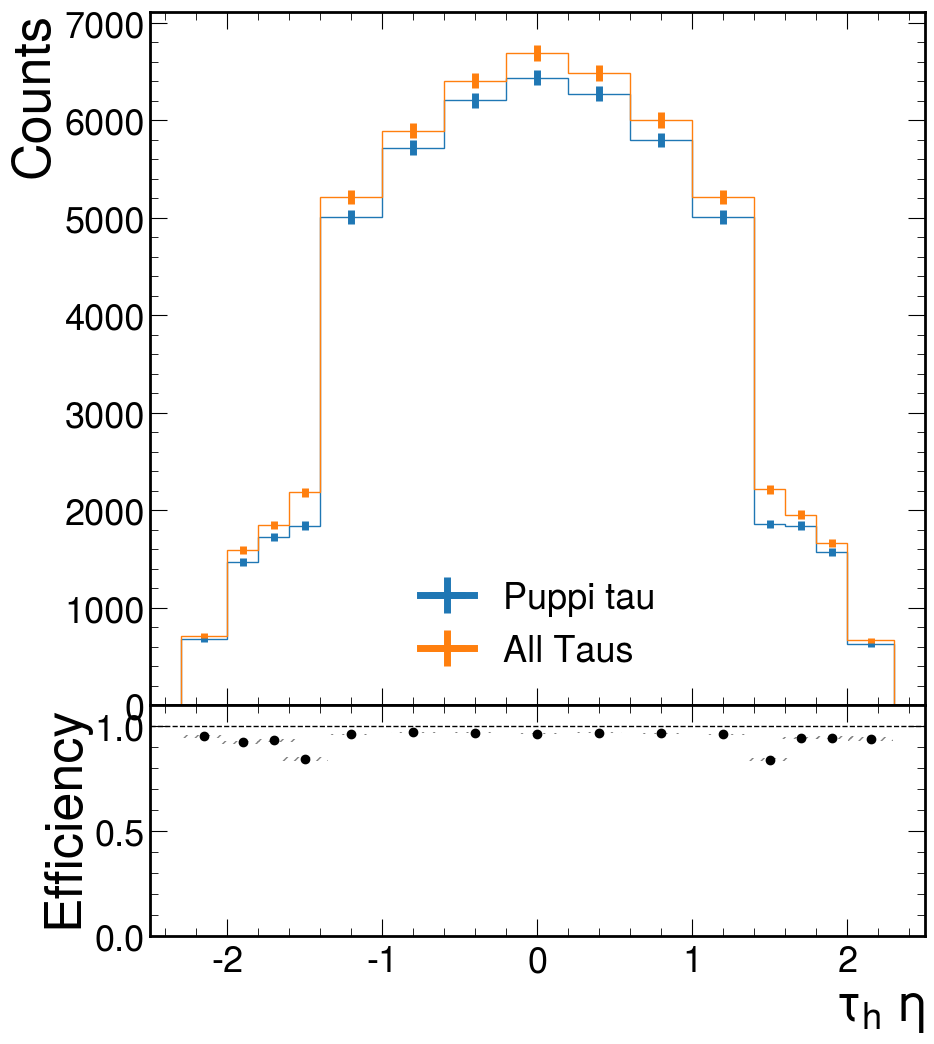

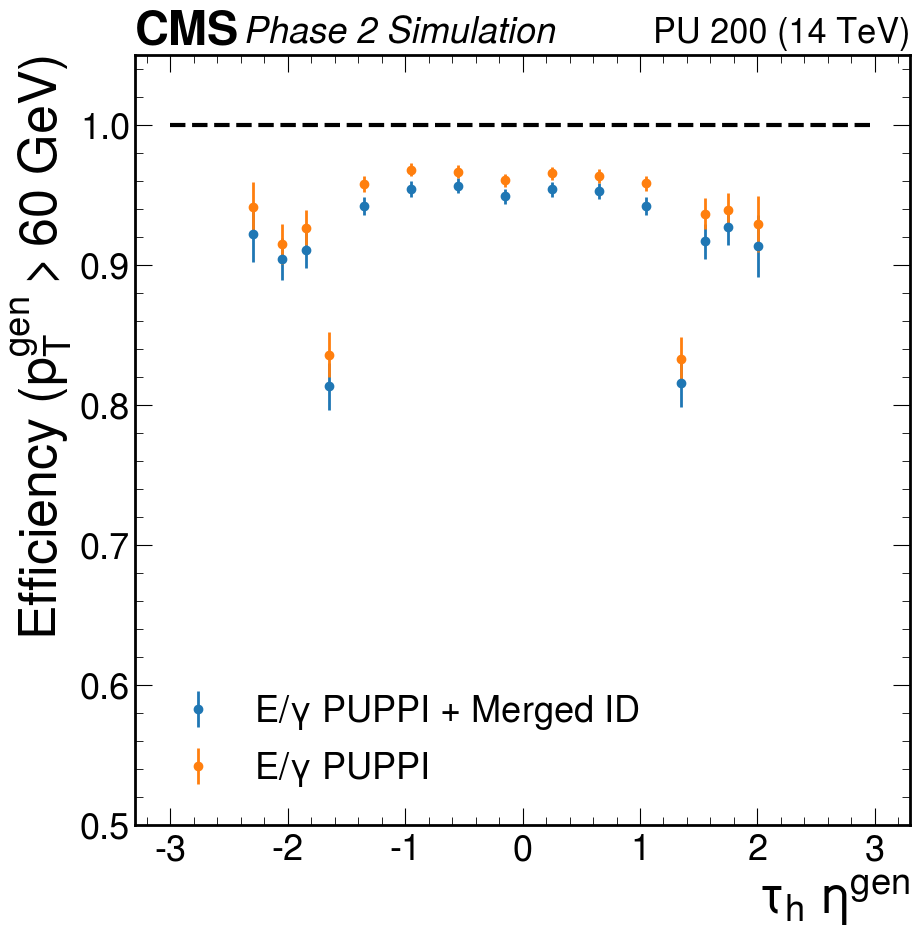

In [12]:
plot_eta_eff_puppi(model_merged_quantized_pruned,
                   '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                   cut_point = 0.22,
                   corrected_pt_cut = 34)

### Background Rate

In [120]:
def background_rate(MinBias_path, test_index = 400000):
    MinBias = uproot4.open(MinBias_path)
    MinBias_id = np.asarray(MinBias['ntuplePupSingle']['tree']['event'].array())[test_index:]
    MinBias_iso = np.asarray(MinBias['ntuplePupSingle']['tree']['chargedIso'].array())[test_index:]
    MinBias_pt = np.asarray(MinBias['ntuplePupSingle']['tree']['pt'].array())[test_index:]
    MinBias_inputs = np.nan_to_num(np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array())[test_index:])

    n_event = np.unique(MinBias_id).shape[0]

    MinBias_nn_score_model = model_jetID_separate.predict(MinBias_inputs)

    MinBias_nn_score_model_merge = model_merged_quantized_pruned.predict(MinBias_inputs)[0]

    MinBias_nn_selected_pt_ratio = model_pt_regress_separate.predict(MinBias_inputs).flatten()

    MinBias_nn_selected_pt_ratio_merge = model_merged_quantized_pruned.predict(MinBias_inputs)[1].flatten()

    MinBias_pt_corrected = np.multiply(MinBias_nn_selected_pt_ratio, MinBias_pt)
    MinBias_pt_corrected_merge = np.multiply(MinBias_nn_selected_pt_ratio_merge, MinBias_pt)
    #print(MinBias_pt)
    #print(MinBias_pt_corrected)
    #print(MinBias_pt_corrected_merge)

    #nn_cut = 0.22 #official NN cut point

    MinBias_nn_no_id = MinBias_id
    MinBias_nn_selected_id = MinBias_id[MinBias_nn_score_model.flatten() > 0.22]
    MinBias_nn_selected_id_merge = MinBias_id[MinBias_nn_score_model_merge.flatten() > 0.21]
    MinBias_nn_selected_pt = MinBias_pt[MinBias_nn_score_model.flatten() > 0.22]
    MinBias_nn_selected_pt_corrected = MinBias_pt_corrected[MinBias_nn_score_model.flatten() > 0.22]
    MinBias_nn_selected_pt_corrected_merge = MinBias_pt_corrected_merge[MinBias_nn_score_model_merge.flatten() > 0.21]

    minbias_rate_no_nn = []
    minbias_rate_nn = []
    minbias_rate_nn_corrected = []
    minbias_rate_nn_corrected_merge = []

    pt_cuts = list(np.arange(0,250,10))

    for pt_cut in pt_cuts:

        print("pT Cut: ", pt_cut)
        n_pass_no_nn = np.unique(MinBias_nn_no_id[MinBias_pt > pt_cut]).shape[0]
        n_pass_nn = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt > pt_cut]).shape[0]
        n_pass_nn_corrected = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt_corrected > pt_cut]).shape[0]
        n_pass_nn_corrected_merge = np.unique(MinBias_nn_selected_id_merge[MinBias_nn_selected_pt_corrected_merge > pt_cut]).shape[0]
        print("Ratio (NN): ", n_pass_nn/n_event)
        print('------------')

        minbias_rate_no_nn.append((n_pass_no_nn/n_event)*32e+3)
        minbias_rate_nn.append((n_pass_nn/n_event)*32e+3) #Convert to kHz (multiply by 32e+3)
        minbias_rate_nn_corrected.append((n_pass_nn_corrected/n_event)*32e+3)
        minbias_rate_nn_corrected_merge.append((n_pass_nn_corrected_merge/n_event)*32e+3)

    plt.plot(pt_cuts, minbias_rate_no_nn, label=r'No NN ID (No $p_T$ correction)', linewidth = 5)
    plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID (separate $p_T$ correction) (Score > 0.22)", linewidth=5)
    plt.plot(pt_cuts, minbias_rate_nn_corrected_merge, label = r"NN ID (merged, quantized, pruned) (Score > 0.21)", linewidth=5)
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.yscale('log')
    plt.ylabel(r"$\tau_h$ trigger rate [kHz]")
    plt.xlabel(r"$p_T$ Cut [GeV]")
    plt.legend(loc = 'upper right',fontsize = 15)
    plt.show()

8869/8869 [==============================] - 7s 742us/step
pT Cut:  0
Ratio (NN):  0.32950041842325484
------------
pT Cut:  10
Ratio (NN):  0.31401086321506955
------------
pT Cut:  20
Ratio (NN):  0.07109642682329907
------------
pT Cut:  30
Ratio (NN):  0.018319833262280327
------------
pT Cut:  40
Ratio (NN):  0.007053984494655235
------------
pT Cut:  50
Ratio (NN):  0.003240806530560687
------------
pT Cut:  60
Ratio (NN):  0.0018079042521276427
------------
pT Cut:  70
Ratio (NN):  0.001026321191164164
------------
pT Cut:  80
Ratio (NN):  0.0006473718282727804
------------
pT Cut:  90
Ratio (NN):  0.0004776340928110148
------------
pT Cut:  100
Ratio (NN):  0.0003157911357428197
------------
pT Cut:  110
Ratio (NN):  0.0002210537950199738
------------
pT Cut:  120
Ratio (NN):  0.00017368512465855084
------------
pT Cut:  130
Ratio (NN):  0.00012631645429712787
------------
pT Cut:  140
Ratio (NN):  0.00011447428670677214
------------
pT Cut:  150
Ratio (NN):  9.47373407228459e-

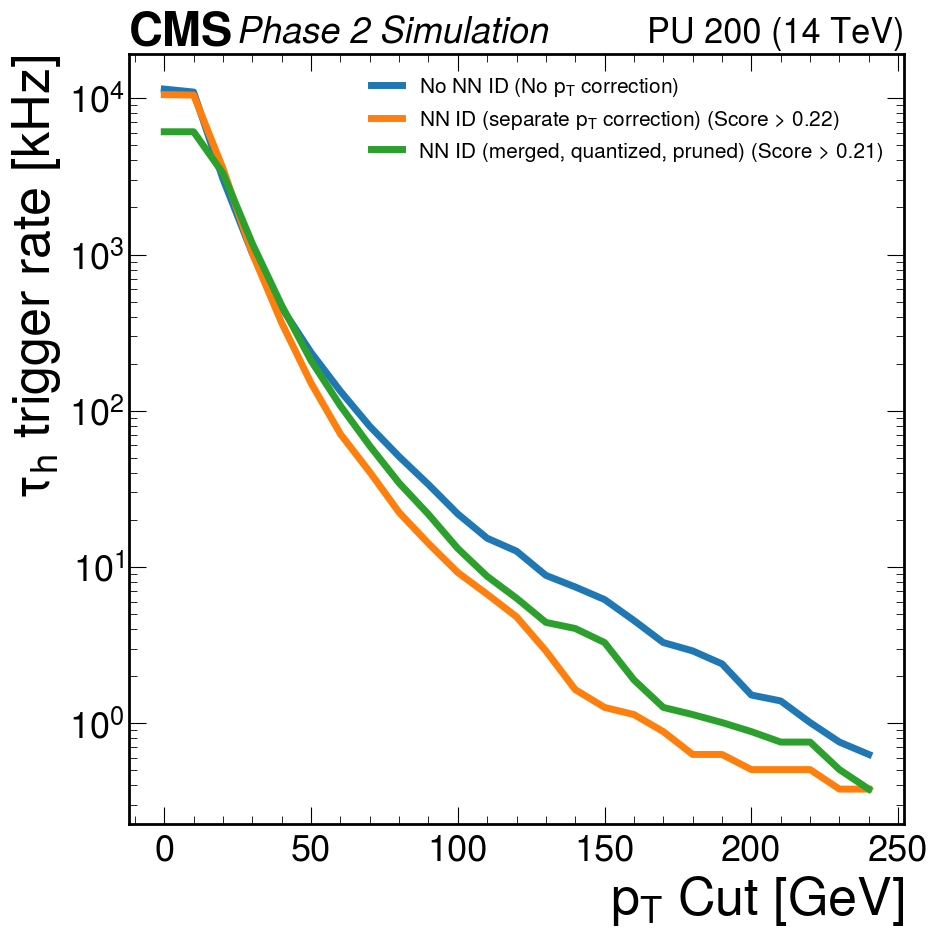

In [121]:
background_rate("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")

### Resolution

In [56]:
def resolution(dir_path, ModelName, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    X_test = np.asarray(inputs[selection])    
    
    if ModelName == model_merged_name:
        model = load_model(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    else:
        model = load_qmodel(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(residual)
    print(sum(residual) / len(residual))
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         alpha = 0.5,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, bin_edges = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    if ModelName == model_merged_name:
    
        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 color = "blue",
                 label='Best fit (merged)')
    elif ModelName == model_merged_quantized_name:
        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 color = "orange",
                 label='Best fit (quantized)')
    elif ModelName == model_merged_quantized_pruned_name:
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 color = "yellow",
                 label='Best fit (quantized + pruned)')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    #plt.show()

    
def resolution_PUPPI(dir_path, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    X_test = np.asarray(inputs[selection])
    
    residual = reco_pt_selected - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         alpha = 0.5,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, bin_edges = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             color = "green",
             label='Best fit (PUPPI)')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.2f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{PUPPI} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    plt.show()


2043/2043 [==============================] - 1s 427us/step
[ 8.2369995  7.4739304 42.383057  ... 12.681709  20.68782   -9.871614 ]
8.15858861188704
-550.64105
5029.233
Error for parameter esimations:  [0.00075275 0.29889418 0.2571782 ]
Standard deviation (fit) is 13.859486040067729
Mean (fit) is 7.1409189220615135


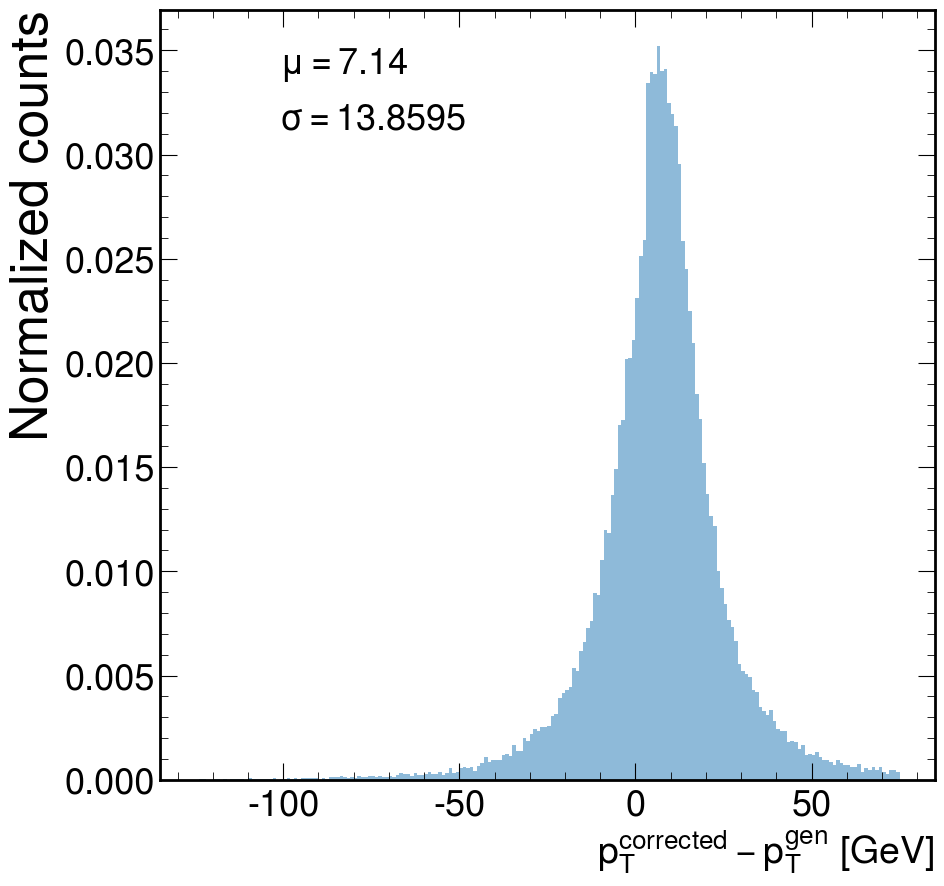

In [25]:
resolution(ntuples_dataset_path, model_pt_regress_separate_name)

2043/2043 [==============================] - 1s 518us/step
[  5.522255     7.3300095   21.790833   ...  13.66383      0.13607788
 -11.371853  ]
1.0819652662795434
-666.8081
4207.126
Error for parameter esimations:  [0.00150081 0.23658229 0.20717462]
Standard deviation (fit) is 8.539091275907
Mean (fit) is 1.541524107817572


/tmp/ipykernel_1551052/3674724419.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bins,


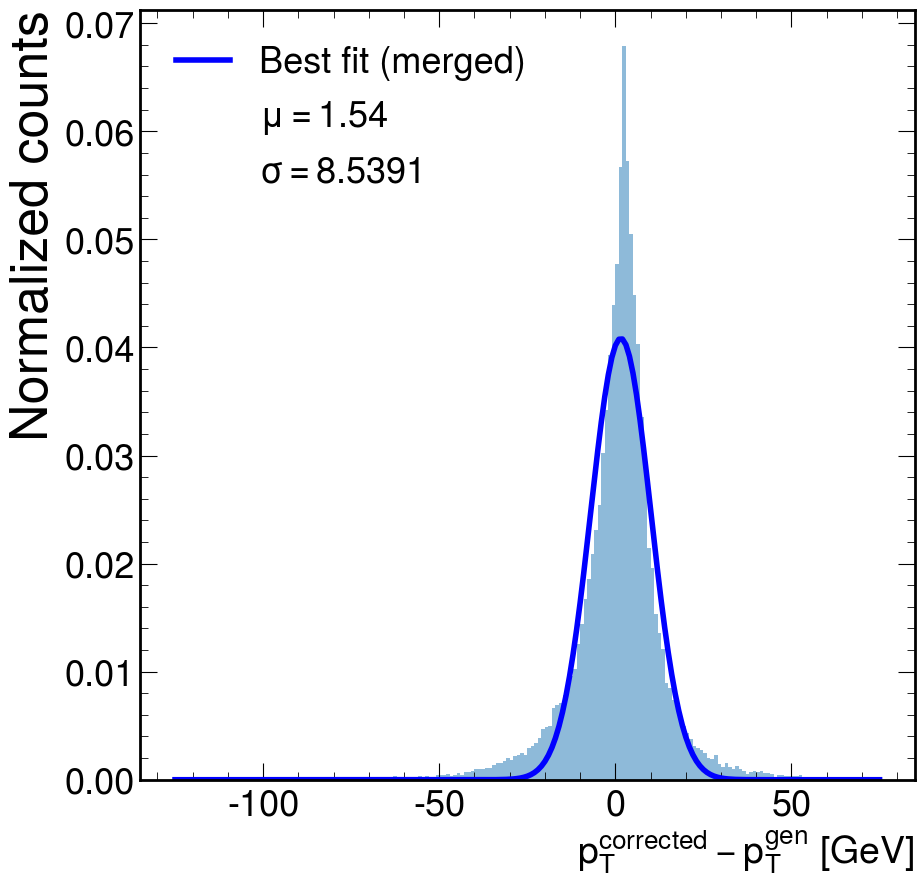

In [7]:
resolution(ntuples_dataset_path, model_merged_name)

2043/2043 [==============================] - 2s 800us/step
[ -3.3489609   12.25193     -0.06999207 ...  14.617062     2.9097214
 -12.1571045 ]
0.905348216213688
-630.61115
3824.7634
Error for parameter esimations:  [0.00171116 0.27126303 0.24340903]
Standard deviation (fit) is 8.426470691607983
Mean (fit) is 0.881346454455535


/tmp/ipykernel_1551052/3674724419.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bins,


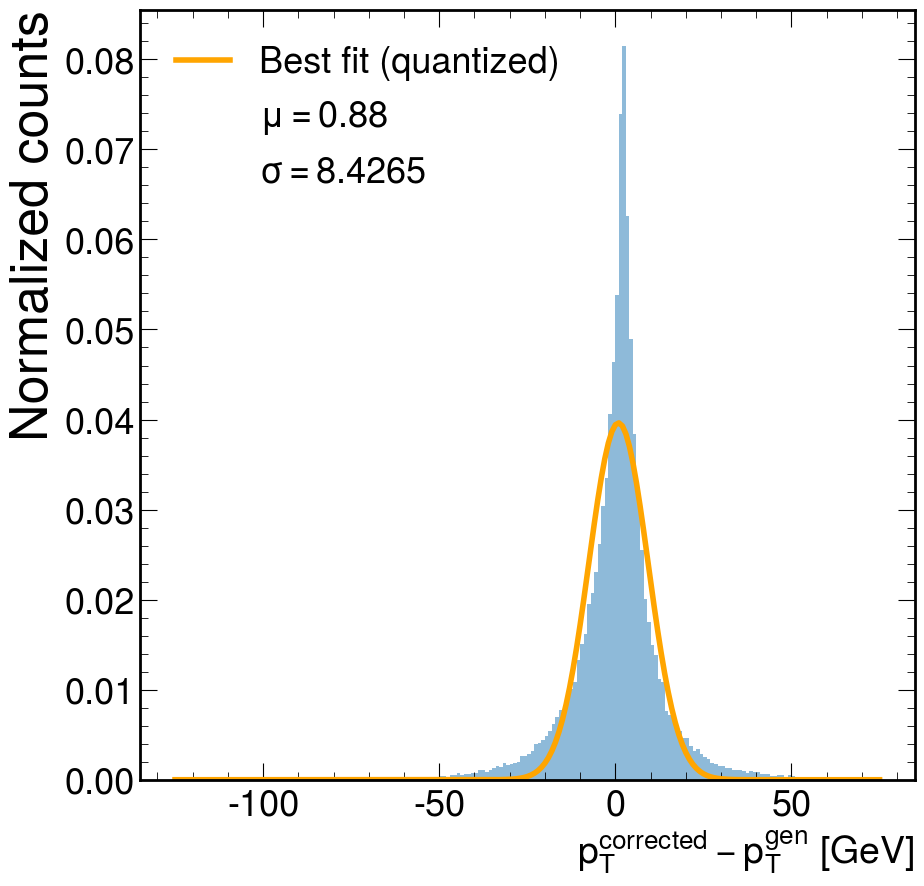

In [8]:
resolution(ntuples_dataset_path, model_merged_quantized_name)

2043/2043 [==============================] - 2s 817us/step
[  6.6656647   7.939148  -36.04956   ...   9.466469    5.087967
 -11.943165 ]
0.8722813594970078
-649.3132
4211.2124
Error for parameter esimations:  [0.00160976 0.27903056 0.24840812]
Standard deviation (fit) is 8.849950049896806
Mean (fit) is 0.935313137010334


/tmp/ipykernel_1551052/3674724419.py:85: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bins,


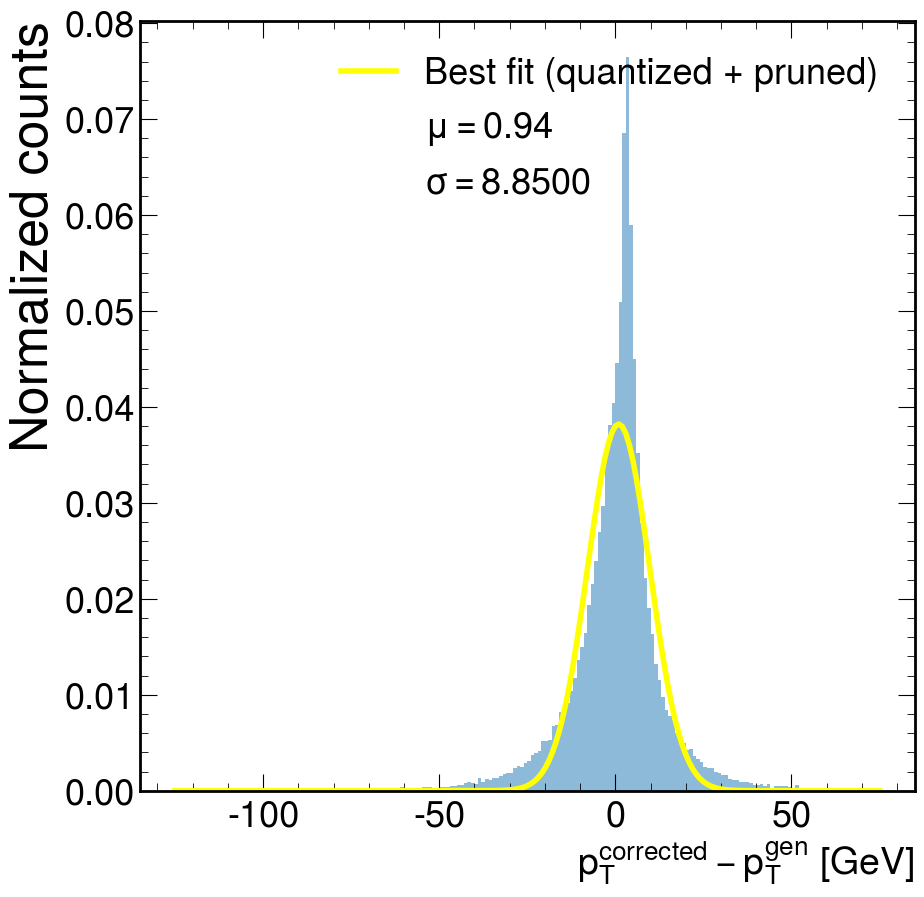

In [9]:
resolution(ntuples_dataset_path, model_merged_quantized_pruned_name)

-651.4521
3806.4905
Error for parameter esimations:  [0.00190064 0.44659747 0.39176167]
Standard deviation (fit) is 9.263166650800915
Mean (fit) is -5.565657627064946


/tmp/ipykernel_2281106/4071712376.py:157: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(bins,


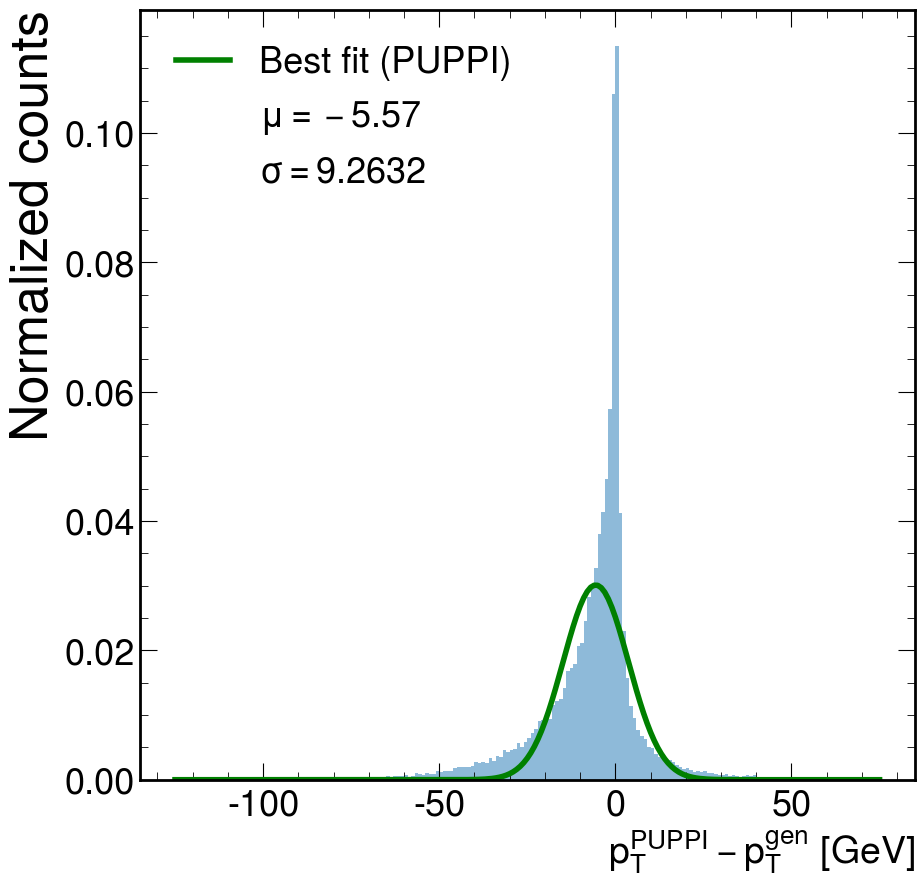

In [18]:
resolution_PUPPI("../../ntuples/Jan_25_2023")

In [123]:
def resolution(dir_path, ModelName, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    X_test = np.asarray(inputs[selection])    
    
    if ModelName == model_merged_name:
        model = load_model(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    else:
        model = load_qmodel(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(residual)
    print(np.mean(residual))
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         alpha = 0.5,
         density = True,
         color = "b")
  
    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, bin_edges = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    mask = data_entries!=0
    #Fit the function to the histogram data.
    
    
    #Error for parameter estimations
    #perr = np.sqrt(np.diag(pcov))
    #print("Error for parameter esimations: ", perr)

    #std_fit = np.abs(popt[2])
    #mean_fit = popt[1]
    
    #print("Standard deviation (fit) is", std_fit)
    #print("Mean (fit) is", mean_fit)
    mean = np.mean(residual)
    plt.plot([],[], 'none', label=r'$\mu_{merged}=%.2f$'%mean, color = "blue")
    plt.plot([],[], 'none', label=r'$RMS_{merged}=%.2f$'%np.sqrt(np.mean(residual**2)))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    #plt.show()

    
def resolution_optimized(dir_path, ModelName, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    X_test = np.asarray(inputs[selection])    
    
    if ModelName == model_merged_name:
        model = load_model(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    else:
        model = load_qmodel(ModelName)
        y_pred = model.predict(X_test)[1].flatten()
    
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(residual)
    print(np.mean(residual))
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         alpha = 0.5,
         density = True,
         color = "orange")
  
    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, bin_edges = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    mask = data_entries!=0
    #Fit the function to the histogram data.
    
    
    #Error for parameter estimations
    #perr = np.sqrt(np.diag(pcov))
    #print("Error for parameter esimations: ", perr)

    #std_fit = np.abs(popt[2])
    #mean_fit = popt[1]
    
    #print("Standard deviation (fit) is", std_fit)
    #print("Mean (fit) is", mean_fit)
    mean = np.mean(residual)
    plt.plot([],[], 'none', label=r'$\mu_{optimized}=%.2f$'%mean, color = "orange")
    plt.plot([],[], 'none', label=r'$RMS_{optimized}=%.2f$'%np.sqrt(np.mean(residual**2)))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    #plt.show()
    
def resolution_PUPPI(dir_path, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    X_test = np.asarray(inputs[selection])
    
    residual = reco_pt_selected - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         alpha = 0.5,
         density = True,
         color = "blue")
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, bin_edges = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    mask = data_entries!=0
    #Fit the function to the histogram data.
    
    
    #Error for parameter estimations
    #perr = np.sqrt(np.diag(pcov))
    #print("Error for parameter esimations: ", perr)

    #std_fit = np.abs(popt[2])
    #mean_fit = popt[1]
    
    #print("Standard deviation (fit) is", std_fit)
    #print("Mean (fit) is", mean_fit)
    
    
    #Plot fitted gaussian
    mean = round(np.mean(residual), 2)
    rms = round(np.sqrt(np.mean(residual**2)), 2)

    plt.plot([],[], 'none', label=r'$\mu_{PUPPI}=%.2f$'%mean, color = "blue")
    plt.plot([],[], 'none', label=r'$RMS_{PUPPI}=%.2f$'%rms)
    
    plt.xlabel("$p_T^{PUPPI/corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()
    plt.show()

    
def resolution_separate(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    print(np.mean(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True,
         alpha = 0.5,
         color = "orange")

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.

    #Error for parameter estimations
   
    
   
    plt.plot([],[], 'none', label=r'$\mu_{NN}=%.2f$'%round(np.mean(residual), 2), color = "orange")
    plt.plot([],[], 'none', label=r'$RMS_{NN}=%.2f$'%round(np.sqrt(np.mean(residual**2)), 2))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()


2043/2043 [==============================] - 1s 413us/step
-738.86786
4544.9214
-1.9492812
-651.4521
3806.4905


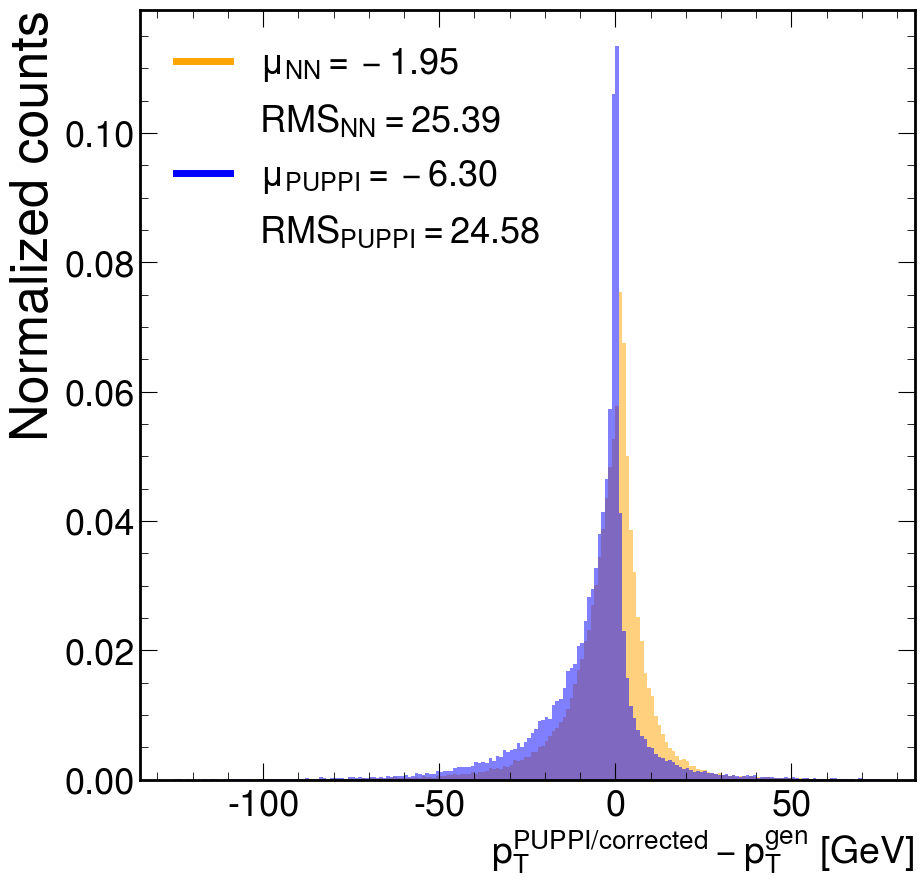

In [104]:
resolution_separate("../../ntuples/Jan_25_2023", load_model("../models/pt_regress_v1_bestest.h5"))
resolution_PUPPI("../../ntuples/Jan_25_2023")

2043/2043 [==============================] - 1s 501us/step
[  5.522255     7.3300095   21.790833   ...  13.66383      0.13607788
 -11.371853  ]
1.0819653
-666.8081
4207.126
2043/2043 [==============================] - 1s 409us/step
-738.86786
4544.9214
-1.9492812


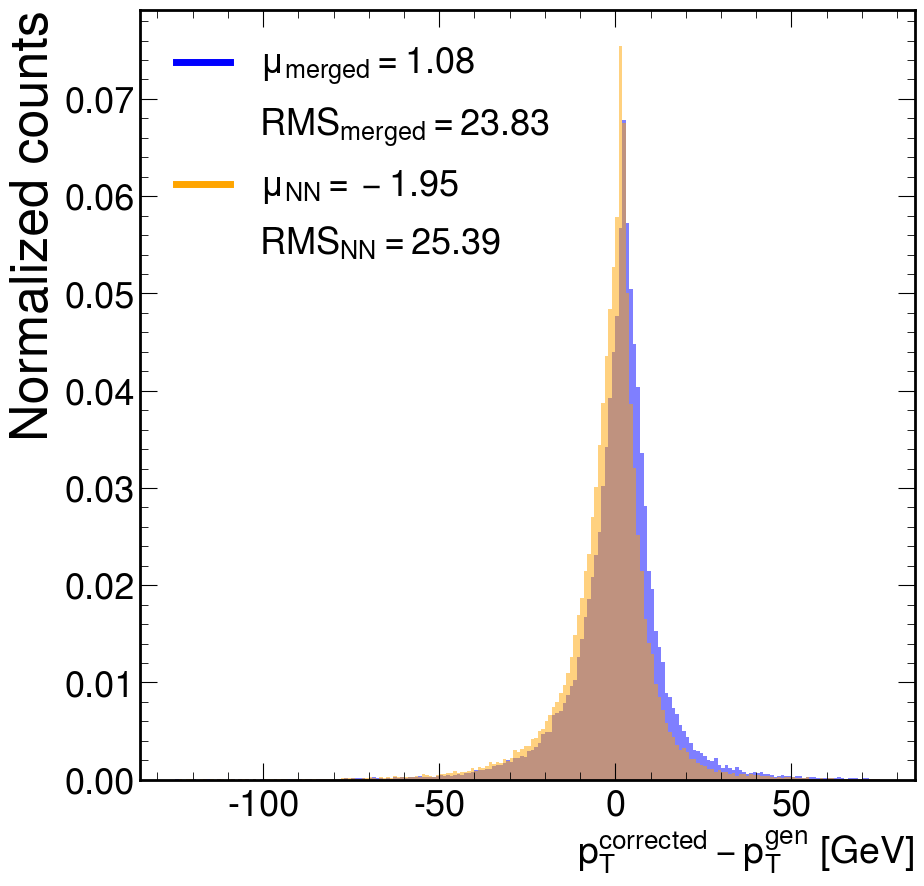

In [105]:
resolution(ntuples_dataset_path, model_merged_name)
resolution_separate("../../ntuples/Jan_25_2023", load_model("../models/pt_regress_v1_bestest.h5"))

2043/2043 [==============================] - 1s 533us/step
[  5.522255     7.3300095   21.790833   ...  13.66383      0.13607788
 -11.371853  ]
1.0819653
-666.8081
4207.126


2043/2043 [==============================] - 2s 747us/step
[  6.6656647   7.939148  -36.04956   ...   9.466469    5.087967
 -11.943165 ]
0.8722814
-649.3132
4211.2124


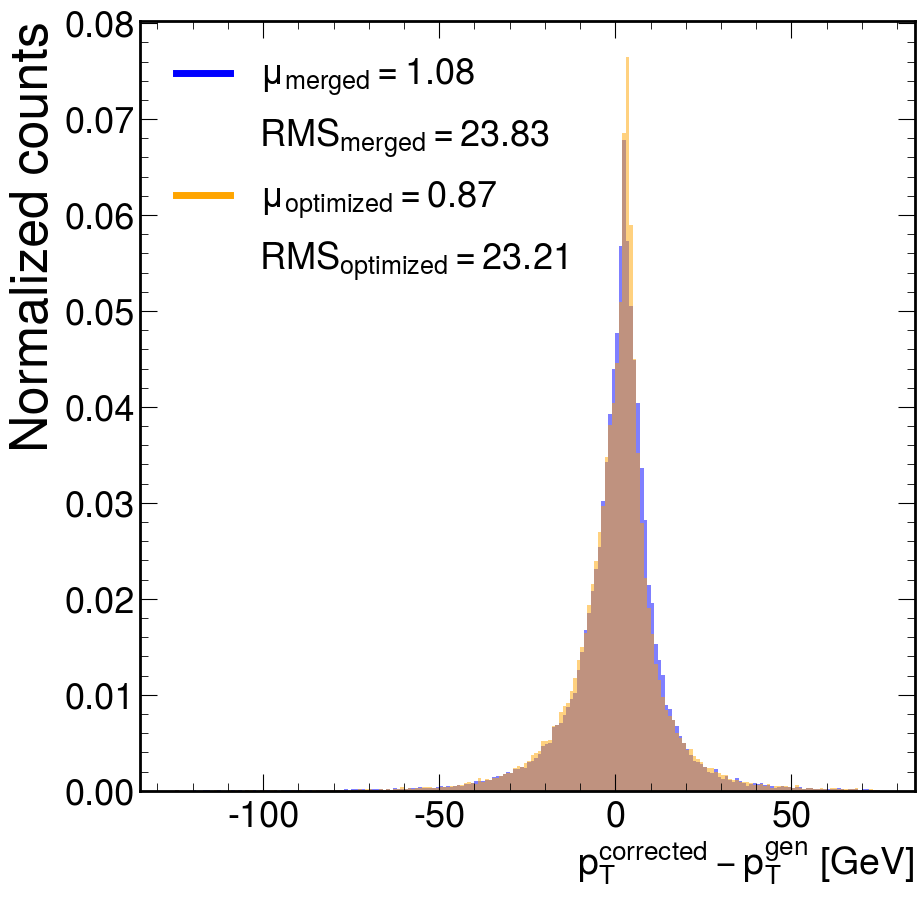

In [124]:
resolution(ntuples_dataset_path, model_merged_name)
resolution_optimized(ntuples_dataset_path, model_merged_quantized_pruned_name)